In [1]:
import sys
sys.path.append('..')
sys.path.append('../..')
from data_utils import *
from waveforms.make_waveform import BatchedLightSimulation

import torch
import numpy as np
import pickle
from torch.utils.data import DataLoader, random_split
from torch.utils.data import Subset
import importlib
import wandb
import torch.optim as optim
from torch.optim.lr_scheduler import SequentialLR, LinearLR, CosineAnnealingLR
import matplotlib.gridspec as gridspec
import random
import matplotlib.colors as mcolors

import matplotlib.pyplot as plt

In [2]:
device = torch.device('cuda:0')
sim = BatchedLightSimulation(cfg="../../waveforms/templates/waveform_sim.yaml").to(device)
# Changing Resolution
params = dict()
params['light_tick_size'] = 0.001 # 100 picoseconds in microseconds units
params['downsample_factor'] = 10
params['tpb_tau'] = 0.002
sim.reconfigure(params)
print(sim.light_tick_size)
print(sim.downsample_factor)
offset = 10
nticks = 80000

BatchedLightSimulation Config:
	SINGLET_FRACTION: uniform(0.1, 0.5)
	LIGHT_OSCILLATION_PERIOD: uniform(0.05, 0.20)
	LIGHT_RESPONSE_TIME: uniform(0.01, 0.10)
	LIGHT_GAIN: uniform(-50.0, -20.0)
	TAU_S: uniform(0.0001, 0.01)
	TAU_T: uniform(0.9, 2.1)
	
	NOMINAL_SINGLET_FRACTION: 0.000000001 #0.35
	NOMINAL_LIGHT_OSCILLATION_PERIOD: 0.11     # us
	NOMINAL_LIGHT_RESPONSE_TIME: 0.055         # us^-1
	NOMINAL_TAU_S: 0.001                       # us
	NOMINAL_TAU_T: 1.530                       # us
	NOMINAL_LIGHT_GAIN: -45.0                  # ADC us/pe
	
	LIGHT_TICK_SIZE: 0.001
	LIGHT_WINDOW: [1, 10]
0.001
10


### Sanity Check: Waveform Shape
- Rising edge should be a few nanoseconds to peak

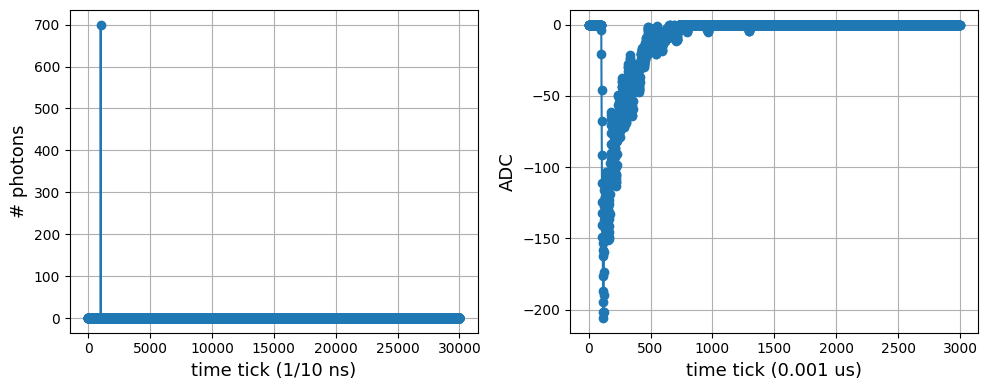

In [25]:
# Generating Waveform
pmt_ids = torch.zeros(700, dtype=torch.int64)
arrival_times = torch.zeros(700, dtype=torch.int64) + 1000 # units of 1/10 ns
wf = sim.gen_waveform(mode='precise', pmt_ids=pmt_ids, arrival_times=arrival_times, n_pmts=1)

# Electronics Convolution
output, _ = sim(wf.to(device), scintillation=False, tpb_delay=False, combined=True)
output = output.detach().cpu().numpy()

fig, axes = plt.subplots(1, 2, figsize=(10, 4))  # 1 row, 2 columns

# First plot
axes[0].plot(wf[0][:30000], marker = 'o')
axes[0].set_ylabel("# photons", fontsize=13)
axes[0].set_xlabel("time tick (1/10 ns)", fontsize=13)
axes[0].grid(True)

# Second plot
axes[1].plot(output[:3000], marker='o')
axes[1].grid(True)
axes[1].set_xlabel(f"time tick ({sim.light_tick_size} us)", fontsize=13)
axes[1].set_ylabel("ADC", fontsize=13)

plt.tight_layout()
plt.show()

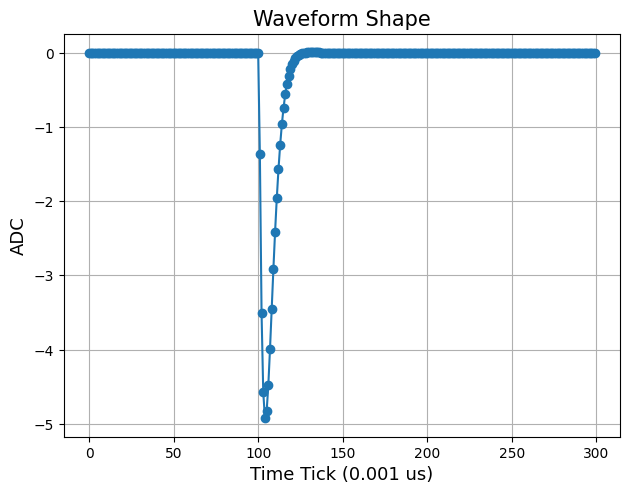

In [50]:
# Second plot
plt.plot(output[:300], marker='o')
plt.grid(True)
plt.xlabel(f"Time Tick ({sim.light_tick_size} us)", fontsize=13)
plt.ylabel("ADC", fontsize=13)
plt.tight_layout()
plt.title("Waveform Shape", fontsize=15)
plt.show()

### Generating `n` photon samples, every 100  picoseconds within 1 nanosecond

In [28]:
num_waveforms = 100000
nphotons = 1
singlephoton_amp = 4.8

####################################################
per_wf_num_photons = []

sim_waveforms = []
arrival_times_list = []
numbers = np.arange(4000, 4010) # array([4000, 4001, ..., 4009])
all_arrival_times = np.repeat(numbers, (num_waveforms * nphotons) / numbers.shape[0])
print(all_arrival_times.shape)

for i in range(num_waveforms):
    pmt_ids = torch.full((nphotons,), 0, dtype=torch.int64)  # PMT 0 for all photons
    arrival_times = all_arrival_times[nphotons*i:nphotons*i+nphotons]
    arrival_times_tensor = torch.tensor(arrival_times)
    arrival_times_list.append(arrival_times_tensor / sim.downsample_factor)

    per_wf_num_photons.append([1] * nphotons)
    
    
    wf = sim.gen_waveform(mode='precise', pmt_ids=pmt_ids, arrival_times=arrival_times_tensor, n_pmts=1)
    output, info = sim(wf.to(device), scintillation=False, tpb_delay=False, combined=False)
    output = output.detach().cpu().numpy()
    
    # adding some noise AFTER generating the waveform
    noise = torch.normal(mean=0.0, std=(0.2 * singlephoton_amp), size=output.shape)
    signal = output + noise.numpy()
    ##################################################

    sim_waveforms.append(signal) # instead of output

data = {}
data['waveforms'] = sim_waveforms
data['arrival_times'] = arrival_times_list
data['num_photons'] = per_wf_num_photons

np.save("full_1photon.npy", data, allow_pickle=True)

(100000,)


### Inspecting Generated Data

Text(0.5, 1.0, 'Input 1D Waveform with 1-photon Signal')

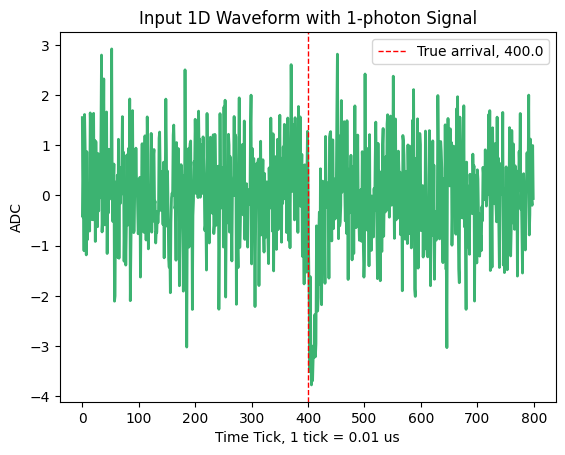

In [29]:
waveforms = np.load('full_1photon.npy', allow_pickle=True).item()
ticks = np.arange(len(waveforms['waveforms'][0]))

for i, wf in enumerate(waveforms['waveforms'][:1]):
    plt.plot(ticks, wf, linewidth=2, color='mediumseagreen')
    for j, t in enumerate(waveforms['arrival_times'][i]):
        # print(waveforms['arrival_times'][i])
        plt.axvline(
            x=t.item(), 
            color='r', 
            linestyle='--', 
            linewidth=1, 
            label=f'True arrival, {t.item():.1f}' if j == 0 else ""
        )

plt.xlabel(f"Time Tick, 1 tick = {sim.light_tick_size * sim.downsample_factor} us")
plt.ylabel("ADC")
plt.legend()
plt.title(f"Input 1D Waveform with {nphotons}-photon Signal")

In [30]:
print(np.unique(waveforms['arrival_times']))


[400.  400.1 400.2 400.3 400.4 400.5 400.6 400.7 400.8 400.9]


### Generating a Training Sample for SINGLE Hit per Window
**Parameters**
- `window_size` = 800 ns (easy to downsample / upsample cleanly in UNet)

**Data Qualities**
- Random arrival times between 50 and 750 ns with resolution at 100-picosecond level
- Random photons per signal between 1 and 10

In [86]:
num_waveforms = 100000
offset = 0

nphotons = np.random.randint(1, 2, num_waveforms)  # random integers between 1 and 1000
all_arrival_times = np.random.randint(50, 7501, size=num_waveforms)
sim_waveforms = []

for i, n in enumerate(nphotons):
    pmt_ids = torch.full((n,), 0, dtype=torch.int64)  # PMT 0 for all photons
    arrival_time = int(all_arrival_times[i])  # convert to int for torch.full
    arrival_times_tensor = torch.full((n,), arrival_time, dtype=torch.int64)

    wf = sim.gen_waveform(mode='precise', pmt_ids=pmt_ids, arrival_times=arrival_times_tensor, n_pmts=1)
    output, info = sim(wf.to(device), scintillation=False, tpb_delay=False, combined=False)
    output = output.detach().cpu().numpy()

    # adding some noise AFTER generating the waveform
    noise = torch.normal(mean=0.0, std=(0.2 * 4.8), size=output.shape)
    signal = output + noise.numpy()
    #################################################
    
    sim_waveforms.append(signal) # instead of output

data = {}
data['waveforms'] = sim_waveforms
data['arrival_times'] = (all_arrival_times / sim.downsample_factor) #+ (offset / sim.downsample_factor)

np.save("testtest.npy", data, allow_pickle=True)

650.4
420.5
549.0
614.5
315.9
411.2
174.2


Text(0.5, 1.0, 'Input 1D Waveforms')

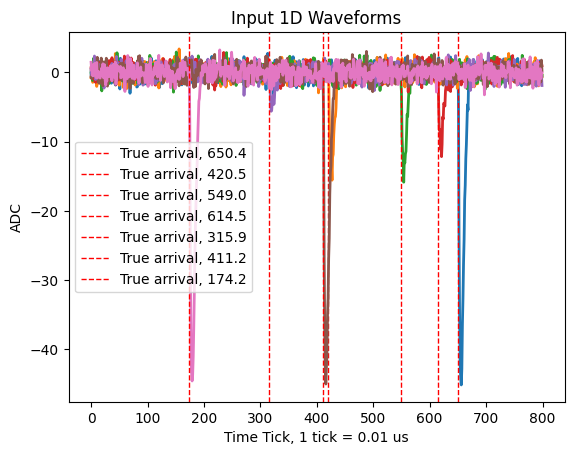

In [87]:
waveforms = np.load('test_random.npy', allow_pickle=True).item()
ticks = np.arange(len(waveforms['waveforms'][0]))

for i, wf in enumerate(waveforms['waveforms'][:7]):
    plt.plot(ticks, wf, linewidth=2)
    # for j, t in enumerate(waveforms['arrival_times'][i]):
    t = waveforms['arrival_times'][i]
    print(t)
    plt.axvline(
        x=t.item(), 
        color='r', 
        linestyle='--', 
        linewidth=1, 
        label=f'True arrival, {t.item():.1f}'
    )

plt.xlabel(f"Time Tick, 1 tick = {sim.light_tick_size * sim.downsample_factor} us")
plt.ylabel("ADC")
plt.legend()
plt.title(f"Input 1D Waveforms")

### Generating a Training Sample for Multiple Hits per Window - Classification & Regression on # Photons
**Parameters**
- `window_size` = 800 ns (easy to downsample / upsample cleanly in UNet)
- `hits_per_window` = 17 (likely to get a few within 5 ns)

**Data Qualities**
- Random arrival times between 50 and 750 ns with resolution at 100-picosecond level
- Random photons per signal between 1 and 10

In [6]:
num_waveforms = 100000
offset = 0
hits_per_waveform = 17

nphotons = np.random.randint(1, 10, num_waveforms * hits_per_waveform)  # random integers between 1 and 10
all_arrival_times = np.random.randint(50, 7501, size=num_waveforms * hits_per_waveform)
sim_waveforms = []

# To save with waveform ids
per_wf_arrival_times = []
per_wf_num_photons = []

for i in range(num_waveforms):
    ns = nphotons[17*i : 17*(i+1)] # 17 unique values
    per_wf_num_photons.append(ns)
    
    total_photons = ns.sum()
    pmt_ids = torch.full((total_photons,), 0, dtype=torch.int64)  # PMT 0 for all photons - ok
    arrival_times = torch.tensor(all_arrival_times[17*i : 17*(i+1)], dtype=torch.int) # 17 unique values
    per_wf_arrival_times.append((arrival_times / sim.downsample_factor))
    
    arrival_times_tensor = torch.cat([
        torch.full((ns[j],), arrival_times[j], dtype=torch.int)
        for j in range(len(ns))
    ])
    
    wf = sim.gen_waveform(mode='precise', pmt_ids=pmt_ids, arrival_times=arrival_times_tensor, n_pmts=1)
    output, info = sim(wf.to(device), scintillation=False, tpb_delay=False, combined=False)
    output = output.detach().cpu().numpy()

    # adding some noise AFTER generating the waveform
    noise = torch.normal(mean=0.0, std=(0.2 * 4.8), size=output.shape)
    signal = output + noise.numpy()
    #################################################
    
    sim_waveforms.append(signal) # instead of output

data = {}
data['waveforms'] = sim_waveforms
data['arrival_times'] = per_wf_arrival_times #+ (offset / sim.downsample_factor)
data['num_photons'] = per_wf_num_photons
np.save("class_reg_100k.npy", data, allow_pickle=True)

Text(0.5, 1.0, 'Input 1D Waveforms')

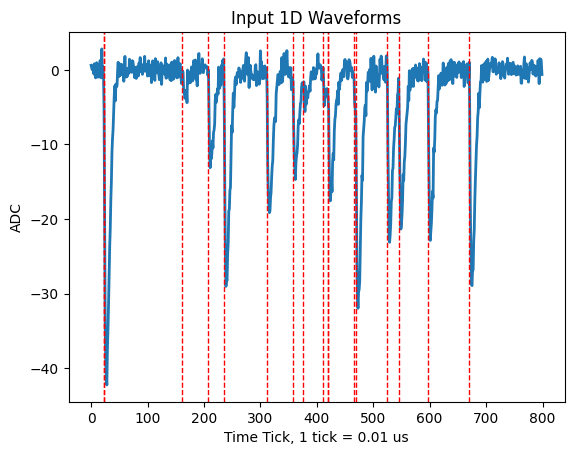

In [7]:
waveforms = np.load('class_reg_100k.npy', allow_pickle=True).item()
ticks = np.arange(len(waveforms['waveforms'][0]))

waveform_id = 7

wf = waveforms['waveforms'][waveform_id]
plt.plot(ticks, wf, linewidth=2)
t = waveforms['arrival_times'][waveform_id]
for i, elem in enumerate(np.sort(t)):
    plt.axvline(
        x=elem.item(), 
        color='r', 
        linestyle='--', 
        linewidth=1, 
        label=f"True arrival, {elem.item():.1f}, {waveforms['num_photons'][waveform_id][i]}"
    )

plt.xlabel(f"Time Tick, 1 tick = {sim.light_tick_size * sim.downsample_factor} us")
plt.ylabel("ADC")
# plt.legend()
plt.title(f"Input 1D Waveforms")

### Generating `n` start times & sampling `k` photons from full delay distribution per start time
Includes
- scintillation delay
- TPB re-emission delay

#### First, create a base distribution: Assign some number of photons to each group start time.

In [16]:
num_waveforms = 200000
offset = 0
max_hits = 8

sim_waveforms = []
per_wf_arrival_times = []
per_wf_num_photons = []

for i in range(num_waveforms):
    nhits = np.random.randint(2, max_hits + 1) # hits per wf
    ns = np.random.randint(10, 1001, size=nhits) # photons per hit
    per_wf_num_photons.append(ns)
    
    total_photons = ns.sum()
    pmt_ids = torch.full((total_photons,), 0, dtype=torch.int64)  # PMT 0 for all photons - ok
    arrival_times = np.random.randint(50, 78001, size=nhits)
    per_wf_arrival_times.append(arrival_times / sim.downsample_factor)
    
    arrival_times_tensor = torch.cat([
        torch.full((ns[j],), arrival_times[j], dtype=torch.int64)
        for j in range(len(ns))
    ])
    
    wf = sim.gen_waveform(mode='precise', pmt_ids=pmt_ids, arrival_times=arrival_times_tensor, n_pmts=1)
    output, info = sim(wf.to(device), combined=True)
    output = output.detach().cpu().numpy()

    # adding some noise AFTER generating the waveform
    noise = torch.normal(mean=0.0, std=(0.2 * 4.8), size=output.shape)
    signal = output + noise.numpy()
    #################################################
    
    sim_waveforms.append(signal) # instead of output

data = {}
data['waveforms'] = sim_waveforms
data['arrival_times'] = per_wf_arrival_times
data['num_photons'] = per_wf_num_photons
np.save("/sdf/home/c/carsmith/sdf_data/flash_detection_data/flash_files/delay_200ks/2_8.npy", data, allow_pickle=True)

#### Inspect

Arrival times (in ticks): [2375.3 3442.3 5429.1 2052.4]


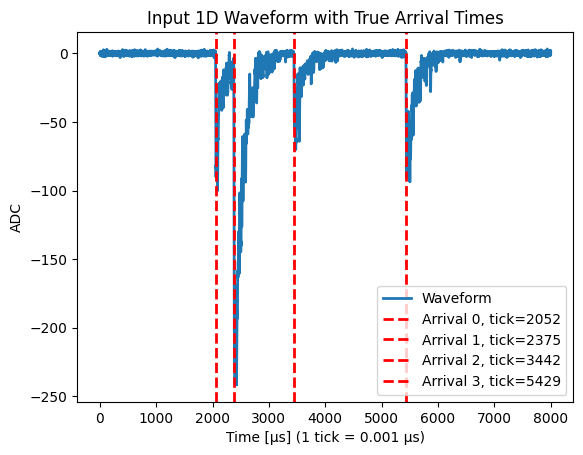

In [17]:
waveforms = np.load("/sdf/home/c/carsmith/sdf_data/flash_detection_data/flash_files/delay_200ks/2_8.npy", allow_pickle=True).item()
waveform_id = 2

wf = waveforms['waveforms'][waveform_id]

# X-axis in physical time units (us)
ticks = np.arange(len(wf))
plt.plot(ticks, wf, linewidth=2, label="Waveform")

# Arrival times for this waveform
t = waveforms['arrival_times'][waveform_id]
print("Arrival times (in ticks):", t)

# Overlay arrival times as vertical dashed lines
for j, elem in enumerate(np.sort(t)):
    plt.axvline(
        x=elem,   # convert arrival ticks → time
        color="r",
        linestyle="--",
        linewidth=2,
        label=f"Arrival {j}, tick={int(elem)}"
    )

plt.xlabel(f"Time [µs] (1 tick = {sim.light_tick_size} µs)")
plt.ylabel("ADC")
plt.title("Input 1D Waveform with True Arrival Times")
plt.legend()
plt.show()

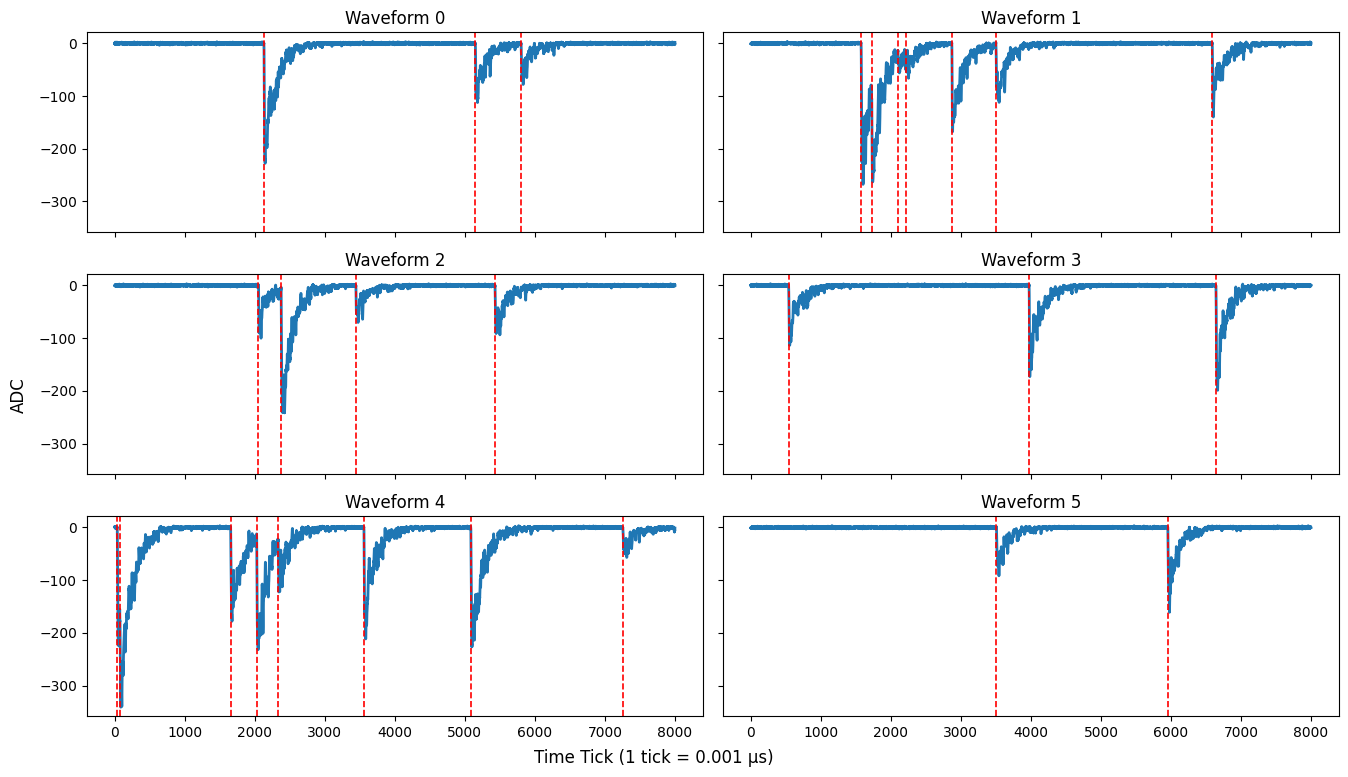

In [90]:
waveforms = np.load("/sdf/home/c/carsmith/sdf_data/flash_detection_data/flash_files/delay_200ks/2_8.npy", allow_pickle=True).item()
ticks = np.arange(len(waveforms['waveforms'][0]))

fig, axes = plt.subplots(3, 2, figsize=(14, 8), sharex=True, sharey=True)
axes = axes.flatten()

for waveform_id in range(6):  # Only 6 plots now
    ax = axes[waveform_id]
    wf = waveforms['waveforms'][waveform_id]
    ax.plot(ticks, wf, linewidth=2)
    
    t = waveforms['arrival_times'][waveform_id]
    for elem in np.sort(t):
        ax.axvline(
            x=elem.item(),
            color='r',
            linestyle='--',
            linewidth=1.2,
        )
    
    ax.set_title(f"Waveform {waveform_id}", fontsize=12)

fig.text(0.5, 0.04, f"Time Tick (1 tick = {sim.light_tick_size} µs)", ha='center', fontsize=12)
fig.text(0.04, 0.5, "ADC", va='center', rotation='vertical', fontsize=12)
plt.tight_layout(rect=[0.05, 0.05, 1, 1])
plt.show()

### Generating 2 start times between 50 & 1100 ns apart & sampling 500 photons from full delay distribution per start time
Includes
- scintillation delay
- TPB re-emission delay

In [8]:
# for sampling variable photons
def make_samples_by_ratio(n_per_bin=10000):
    ratio_bins = [(0.1,0.2), (0.2,0.5), (0.5,1.0), (1.0,2.0), (2.0,5.0), (5.0,7.0), (7.0, 10.0)]
    samples = []
    for (rmin,rmax) in ratio_bins:
        rs = np.exp(np.random.uniform(np.log(rmin), np.log(rmax), size=n_per_bin))  # log-uniform in bin
        # choose total photons (T) — could be uniform or log-uniform
        T = np.random.randint(10, 1001, size=n_per_bin)
        x = np.round(T * (rs / (1+rs))).astype(int)
        y = np.round(T * (1/(1+rs))).astype(int)
        # clamp to bounds
        x = np.clip(x, 10, 1000)
        y = np.clip(y, 10, 1000)
        for xi, yi in zip(x,y):
            samples.append((xi, yi))
    return np.array(samples)  # shape (N,2)

In [9]:
separations = np.array([50, 100, 300, 500, 700, 900, 1100]) * 10 # ns
samples_per_val = 10000
# num_waveforms = samples_per_val * len(separations)
num_waveforms = 10 * samples_per_val
# samples = make_samples_by_ratio(n_per_bin=samples_per_val)

# Exactly 2 hits per waveform
offset = 0
max_hits = 2

sim_waveforms = []
per_wf_arrival_times = []
per_wf_num_photons = []

for i in range(num_waveforms):
    nhits = max_hits # hits per wf
    # ns = np.random.randint(10, 1000, size=2)
    # ns = np.array(list(samples[i]))
    ns = np.array([200, 200])
    per_wf_num_photons.append(ns)
    
    total_photons = ns.sum()
    pmt_ids = torch.full((total_photons,), 0, dtype=torch.int64)  # PMT 0 for all photons - ok
    random_separation = np.random.randint(0, 15000, size=1)
    # arrival_times = np.array([4000, 4000 + separations[i // samples_per_val]])
    arrival_times = np.array([40000, 40000 + random_separation[0]])
    per_wf_arrival_times.append(arrival_times / sim.downsample_factor)
    
    arrival_times_tensor = torch.cat([
        torch.full((ns[j],), arrival_times[j], dtype=torch.int64)
        for j in range(len(ns))
    ])
    
    wf = sim.gen_waveform(mode='precise', pmt_ids=pmt_ids, arrival_times=arrival_times_tensor, n_pmts=1)
    output, info = sim(wf.to(device), combined=True)
    output = output.detach().cpu().numpy()

    # adding some noise AFTER generating the waveform
    noise = torch.normal(mean=0.0, std=(0.2 * 4.8), size=output.shape)
    signal = output + noise.numpy()
    #################################################
    
    sim_waveforms.append(signal) # instead of output

data = {}
data['waveforms'] = sim_waveforms
data['arrival_times'] = per_wf_arrival_times
data['num_photons'] = per_wf_num_photons
np.save("/sdf/home/c/carsmith/sdf_data/flash_detection_data/flash_files/delta_t_200phot.npy", data, allow_pickle=True)

Arrival times (in ticks): [4000.  4329.3]


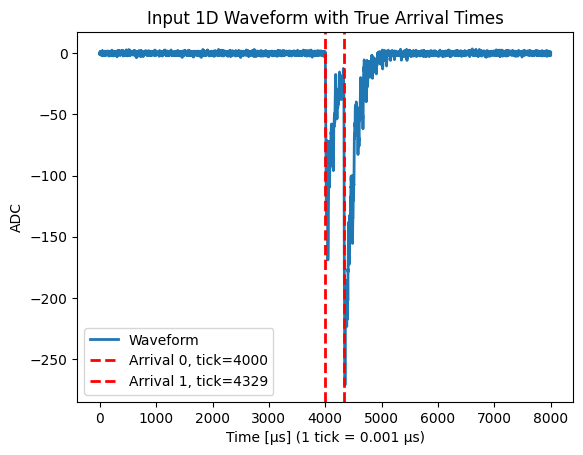

In [18]:
waveforms = np.load("/sdf/home/c/carsmith/sdf_data/flash_detection_data/flash_files/delta_t_random.npy", allow_pickle=True).item()
waveform_id = 12

wf = waveforms['waveforms'][waveform_id]

# X-axis in physical time units (us)
ticks = np.arange(len(wf))
plt.plot(ticks, wf, linewidth=2, label="Waveform")

# Arrival times for this waveform
t = waveforms['arrival_times'][waveform_id]
print("Arrival times (in ticks):", t)

# Overlay arrival times as vertical dashed lines
for j, elem in enumerate(np.sort(t)):
    plt.axvline(
        x=elem,   # convert arrival ticks → time
        color="r",
        linestyle="--",
        linewidth=2,
        label=f"Arrival {j}, tick={int(elem)}"
    )

plt.xlabel(f"Time [µs] (1 tick = {sim.light_tick_size} µs)")
plt.ylabel("ADC")
plt.title("Input 1D Waveform with True Arrival Times")
plt.legend()
plt.show()

### Generating 1 Flash per WF to Study Upper Bound Accuracy vs. Nphotons

In [25]:
photon_max = 1000
samples_per_val = 100

sim_waveforms = []
per_wf_arrival_times = []
per_wf_num_photons = []

for photons in range(10, photon_max):  # start at 10 photons
    for sample in range(samples_per_val):
        ns = np.array([photons])  # photons per hit
        per_wf_num_photons.append(ns)

        total_photons = ns.sum()
        pmt_ids = torch.full((total_photons,), 0, dtype=torch.int64)

        arrival_time = np.random.randint(50, 75001)  # single int
        per_wf_arrival_times.append([arrival_time / sim.downsample_factor])

        arrival_times_tensor = torch.full((total_photons,), arrival_time, dtype=torch.int64)

        wf = sim.gen_waveform(mode='precise', pmt_ids=pmt_ids, arrival_times=arrival_times_tensor, n_pmts=1)
        output, info = sim(wf.to(device), combined=True)
        output = output.detach().cpu().numpy()

        # add Gaussian noise
        noise = np.random.normal(loc=0.0, scale=0.2*4.8, size=output.shape)
        signal = output + noise

        sim_waveforms.append(signal)

data = {
    'waveforms': sim_waveforms,
    'arrival_times': per_wf_arrival_times,
    'num_photons': per_wf_num_photons
}
np.save("/sdf/home/c/carsmith/sdf_data/flash_detection_data/flash_files/1delayphot_reg.npy",
        data, allow_pickle=True)

Arrival times (in ticks): [5225.4]
Num photons: [18]


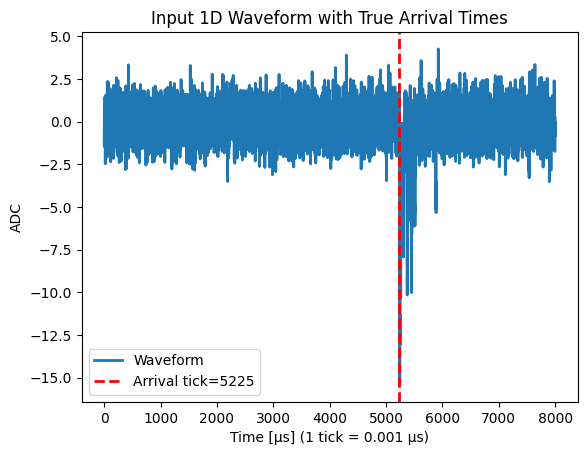

In [27]:
waveforms = np.load("/sdf/home/c/carsmith/sdf_data/flash_detection_data/flash_files/1delayphot_reg.npy", allow_pickle=True).item()
waveform_id = 811

wf = waveforms['waveforms'][waveform_id]

# X-axis in physical time units (us)
ticks = np.arange(len(wf))
plt.plot(ticks, wf, linewidth=2, label="Waveform")

# Arrival times for this waveform
t = waveforms['arrival_times'][waveform_id]
n = waveforms['num_photons'][waveform_id]
print("Arrival times (in ticks):", t)
print("Num photons:", n)


# Overlay arrival times as vertical dashed lines
plt.axvline(
    x=t,   # convert arrival ticks → time
    color="r",
    linestyle="--",
    linewidth=2,
    label=f"Arrival tick={int(t[0])}"
)

plt.xlabel(f"Time [µs] (1 tick = {sim.light_tick_size} µs)")
plt.ylabel("ADC")
plt.title("Input 1D Waveform with True Arrival Times")
plt.legend()
plt.show()